In [22]:
using LinearAlgebra, Plots, Statistics, LaTeXStrings
using Plots.PlotMeasures, Revise
using Zygote

In [23]:
Δ = 0.1
A = [0.98 Δ; 0 0.95];
B = [0; Δ;;];
rₓ, rᵤ = size(B)
C = I;
D = 0;

V = [0.2;;]

Q = 1.0 * I(rₓ)
R = 4.0 * I(rᵤ)
;

In [24]:
θ = 1/3
function f(x::Vector{Float64}, u::Vector{Float64})
    x⁺ = A * x + B * u + [θ * x[2] ^ 2; θ * tanh(x[1]) * u[1]]
    return x⁺
end

function f_dataGen_CL(x₀::Vector{Float64}, K::Matrix{Float64}, N::Int)
    X = zeros(Float64, size(K)[2], N+1)
    U = zeros(Float64, size(K)[1], N)
    X[:,1] = x₀
    for j=1:N
        U[:,j] = K * X[:,j] + sqrt(V) * randn(rᵤ,)
        X[:,j+1] = f(X[:,j], U[:,j])
    end
    return X[:,1:end-1], U
end
;


In [25]:
function ∇ₓf(x₀::Vector{Float64}, u₀::Vector{Float64})
	Zygote.jacobian(x -> f(x, u₀), x₀)[1]
end
function ∇ᵤf(x₀::Vector{Float64}, u₀::Vector{Float64})
	Zygote.jacobian(u -> f(x₀, u), u₀)[1]
end

∇ᵤf (generic function with 1 method)

In [26]:
A_local, B_local = ∇ₓf(zeros(Float64, 2),[0.0]), ∇ᵤf(zeros(Float64, 2),[0.0])

([0.98 0.1; 0.0 0.95], [0.0; 0.1;;])

In [27]:
plt = plot(
    framestyle = :box,
    yguidefontsize = 10,
    xguidefontsize = 10,
    xtickfontsize = 8,
    ytickfontsize = 8,
    palette = :seaborn_muted,
    legend=:none,
    foreground_color_legend = nothing,
    legendfontsize=5,
    fontfamily = "Computer Modern",
    markersize = 2,
);

2-element Vector{Float64}:
 0.05215553368329004
 0.97784446631671

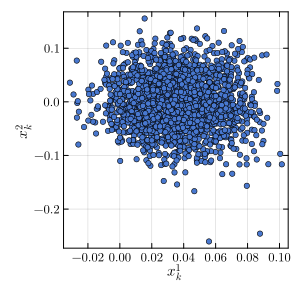

In [28]:
N = 2000
x₀ = zeros(Float64, 2,)
K₀ = [-0.2  -9.0]

X, U = f_dataGen_CL(x₀, K₀, N)
display(abs.(eigen(A + B * K₀).values))

plot_data_exp = scatter(plt, X[1,:], X[2,:], markersize = 3, size = (300, 300), xlabel = L"$x_k^1$", ylabel = L"$x_k^2$") 

In [29]:
using RobustWithLessShifts

In [30]:
K_LQR = Standard_LQR_SDP(A_local, B_local, Q, R, zeros(Float64, rₓ, rₓ), V);

Lyupanov condition error: (L∞ norm) is 2.9435787141096625e-10


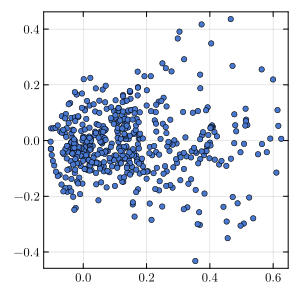

In [31]:
N = 500
x₀ = zeros(Float64, 2,)
X, U = f_dataGen_CL(x₀, K_LQR, N)
plot_data_exp = scatter(plt, X[1,:], X[2,:], markersize = 3, size = (300, 300)) 

In [32]:
function XU_to_params(X, U)
    params = zeros(2, N)
    ABs = fill([], N)
    for k in 1:N
        A_loc, B_loc = ∇ₓf(X[:,k],U[:,k]), ∇ᵤf(X[:,k],U[:,k])
        params[:,k] = [A_loc[1,2], B_loc[2,1]]
        ABs[k] = [A_loc, B_loc]
    end
    return params, ABs
end



XU_to_params (generic function with 1 method)

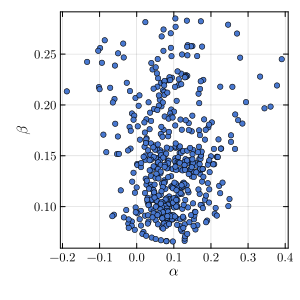

In [33]:
params, ABs = XU_to_params(X, U)
plot_params = scatter(plt, params[1,:], params[2,:], markersize = 3, size = (300, 300), xlabel = L"$\alpha$", ylabel = L"$\beta$") 

In [34]:
K_Robust = Quadratically_Stable_LQR_SDP(ABs, Q, R, zeros(Float64, rₓ, rₓ), V)

1×2 Matrix{Float64}:
 -1.27382  5.27828

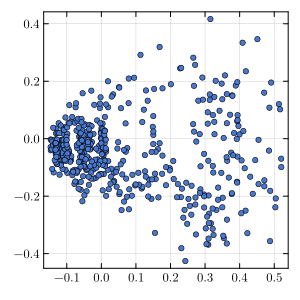

In [35]:
N = 500
x₀ = zeros(Float64, 2,)
X, U = f_dataGen_CL(x₀, K_LQR, N)
plot_data_exp = scatter(plt, X[1,:], X[2,:], markersize = 3, size = (300, 300)) 

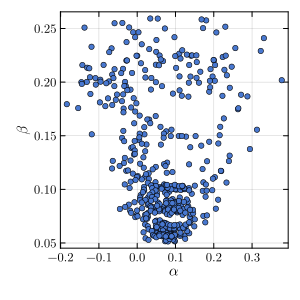

In [36]:
params, ABs = XU_to_params(X, U)
plot_params = scatter(plt, params[1,:], params[2,:], markersize = 3, size = (300, 300), xlabel = L"$\alpha$", ylabel = L"$\beta$") 

In [38]:
γ = 10
K_Robust = Quadratically_Stable_State_Input_Data_Conforming_LQR_SDP(ABs, Q, R, zeros(Float64, rₓ, rₓ), V, X, U, γ)

1×2 Matrix{Float64}:
 1.09881  -5.18681

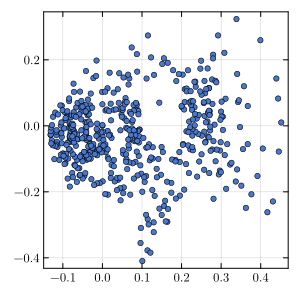

In [39]:
N = 500
x₀ = zeros(Float64, 2,)
X, U = f_dataGen_CL(x₀, K_LQR, N)
plot_data_exp = scatter(plt, X[1,:], X[2,:], markersize = 3, size = (300, 300)) 

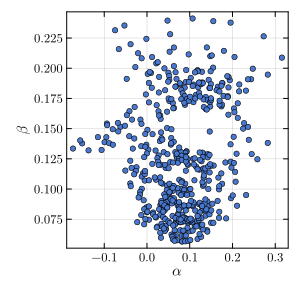

In [40]:
params, ABs = XU_to_params(X, U)
plot_params = scatter(plt, params[1,:], params[2,:], markersize = 3, size = (300, 300), xlabel = L"$\alpha$", ylabel = L"$\beta$") 

In [41]:
Σ_data = 1/(N) * X * X'

2×2 Matrix{Float64}:
  0.0263198    -0.000945037
 -0.000945037   0.0131366

In [42]:
zeros(Float64, 2)

2-element Vector{Float64}:
 0.0
 0.0